<a href="https://colab.research.google.com/github/abhinavsb3/Neural-Network-from-scratch/blob/main/Neural_network_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Building Neural Network and Backpropagation from scratch Based on Micrograd which is from a tutorial of Andrej Karpathy Youtube channel

Link:https://www.youtube.com/watch?v=VMj-3S1tku0&list=PLAqhIrjkxbuWI23v9cThsA9GvCAUhRvKZ&index=1

In [1]:
import math
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

We need to build a Value class for define variables, perform operations on them, and compute gradient autimatically.

Each instance holds data value and can participate in operations like addition, multiplication, and more, storing both result and how it was computed.This step also enables backpropagation, where gradients are calculated for optimization

In [2]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''): #_children is for save operands in an operation. _op is for save the operation in an operations
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self,other), '+')

    def _backward():                                      #now we are adding back propagation for each operaton.
      self.grad +=  1.0 * out.grad                        #Usinf chain rule we get gradient is local derrivative multiplied with global derrivateve.For addition local variable is 1.0 and here gloval variable is out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self,other), '*')

    def _backward():
      self.grad +=  other.data * out.grad                  #Using chain rule
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "Supporting only int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad +=  other*(self.data ** (other-1))*out.grad #Using chain rule
    out._backward = _backward

    return out

  def __rmul__(self, other):                                # other * self
    return self * other

  def __truediv__(self, other):                             # self / other
    return self * other**-1

  def __neg__(self):                                        # -self
    return self * -1

  def __sub__(self, other):                                 # self - other
    return self + (-other)

  def __radd__(self, other):                                # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad           # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward

    return out

  def backward(self):                            #setting up topological sort algorthm for backpropagate through each node of network and set a gradient for each weight values using _bacward() function and also setting last node gradient as 1.0 which is the starting node in backpropagation
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()




Now visualizes the computation graph of Value objects by constructing a graph using Graphviz.

In [3]:
from graphviz import Digraph

def trace(root):
                                                  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
                                                 # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
                                                 # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
                                                 # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
                                                 # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

Now creating sample mathematical expression of a neruon for testing the visualization and backpropagation part.With the below example value we can visualize and test backproopagation of a single neuron.

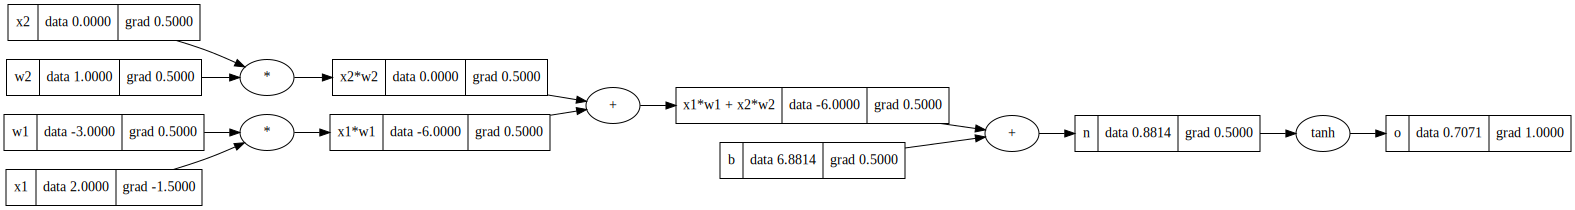

In [6]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

Now we have to create Neural Network


In [18]:
class Neuron:                                        # Defining a Neuron class that represents a single neuron with a configurable number of inputs (nin).
                                                     #Each Neuron instance manages its own weights and bias as attributes, allowing independent adjustment and storage.

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layers:                                         # Defining a Layer class, representing a fully connected layer in a neural network with a specified number of input (nin) and output neurons (nout).
                                                      #Each Layer instance holds a list of Neuron objects, managing the layer's structure and computation.
  def __init__(self,nin,nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self,x):
      outs = [n(x) for n in self.neurons]
      return outs[0] if len(outs) == 1 else outs

  def parameters(self):
      return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:                                            # Defining an MLP (Multi-Layer Perceptron) class, representing a sequence of fully connected layers for building neural networks.
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layers(sz[i],sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

Now testing MLP

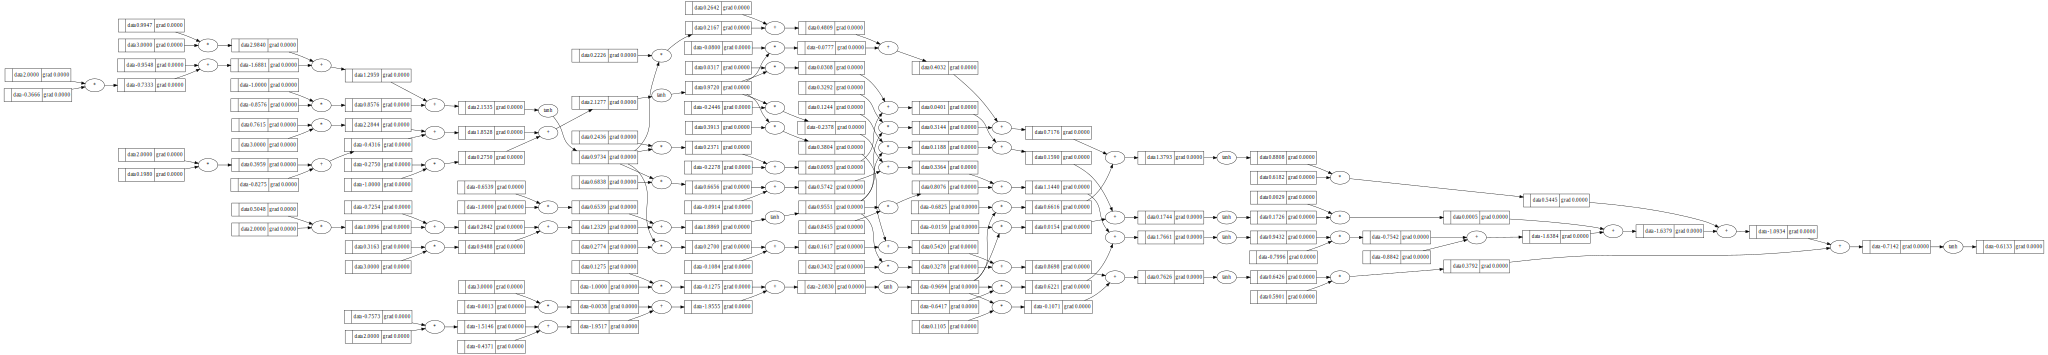

In [19]:
x = [2.0, 3.0, -1.0]                                   #input values
n = MLP(3, [4, 4, 1])                                  #structure of neural network
n(x)
draw_dot(n(x))

Now building training loop for Neural network we have created

In [33]:
xs = [                                                       #Inputs
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]                                 # Targets

In [34]:
for k in range(20):                                          #Here 20 is the number of epochs

  #forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout-ygt)**2 for ygt, yout in zip(ys, ypred))  #defining loss calculation

  #backward pass
  for p in n.parameters():
    p.grad = 0.0                                             #reseting gradient in each loop other wise gradient will add in each loop
  loss.backward()

  #update
  for p in n.parameters():                                  #changing weights.using this posetive value will add to negative gradient weights and nrgative value will add to positive gradients
    p.data += -0.1 * p.grad                                 #-0.1 is the learning rate

  print(k, loss.data)



0 0.0016813557200614977
1 0.0016604335517711147
2 0.0016400231947379684
3 0.0016201061309051694
4 0.0016006647240902122
5 0.0015816821681327044
6 0.0015631424386570913
7 0.0015450302481597742
8 0.0015273310041563934
9 0.0015100307701488385
10 0.001493116229192785
11 0.0014765746498659504
12 0.0014603938544544698
13 0.0014445621891906067
14 0.001429068496389187
15 0.001413902088342852
16 0.001399052722848081
17 0.001384510580244309
18 0.0013702662418581893
19 0.0013563106697536322


In [35]:
ypred

[value(data=0.9752204363456887),
 value(data=-0.9992180917621095),
 value(data=-0.9989375027884215),
 value(data=0.9727870689921414)]